In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import cufflinks as cf
from cufflinks.offline import go_offline
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.model_selection import train_test_split
import pickle
import os

In [2]:
data = pd.read_excel('flight_data.xlsx')

In [3]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
data.isnull().sum()

## train_data.isnull().sum(axis=0)
## by-default axis is 0 , ie it computes total missing values column-wise !

## train_data.isnull().sum(axis=1) -->> if axis=1 , ie it computes total missing values row-wise !

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
data.shape

(10683, 11)

In [7]:
### getting all the rows where we have missing value
data[data['Total_Stops'].isnull()]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
9039,Air India,6/05/2019,Delhi,Cochin,NaN,09:45,09:25 07 May,23h 40m,NaN,No info,7480


In [8]:
data.dropna(inplace = True)

In [9]:
data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              0
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        0
Additional_Info    0
Price              0
dtype: int64

## Pre-process & Perform Featurization of "Date_of_Journey"
    ie pre-process it & extract day,month,year from "Date_of_Journey" feature..

In [10]:
data.dtypes

Airline            object
Date_of_Journey    object
Source             object
Destination        object
Route              object
Dep_Time           object
Arrival_Time       object
Duration           object
Total_Stops        object
Additional_Info    object
Price               int64
dtype: object

In [11]:
def change_into_datetime(col):
    data[col] = pd.to_datetime(data[col])

In [12]:
data.columns

Index(['Airline', 'Date_of_Journey', 'Source', 'Destination', 'Route',
       'Dep_Time', 'Arrival_Time', 'Duration', 'Total_Stops',
       'Additional_Info', 'Price'],
      dtype='object')

In [13]:
for feature in ['Date_of_Journey','Dep_Time', 'Arrival_Time']:
    change_into_datetime(feature)

/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning:

Parsing '24/03/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning:

Parsing '24/06/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning:

Parsing '27/05/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/pandas/core/tools/datetimes.py:1047: UserWarning:

Parsing '18/04/2019' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.

/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packag

In [14]:
data.dtypes

Airline                    object
Date_of_Journey    datetime64[ns]
Source                     object
Destination                object
Route                      object
Dep_Time           datetime64[ns]
Arrival_Time       datetime64[ns]
Duration                   object
Total_Stops                object
Additional_Info            object
Price                       int64
dtype: object

In [15]:
data['Date_of_Journey'].min()

Timestamp('2019-01-03 00:00:00')

In [16]:
data['Date_of_Journey'].max()

Timestamp('2019-12-06 00:00:00')

## lets do Feature Engineering of "Date_of_Journey" & fetch day,month,year !

In [17]:
data['Journey_Day'] = data['Date_of_Journey'].dt.day
data['Journey_Month'] = data['Date_of_Journey'].dt.month
data['Journey_Year'] = data['Date_of_Journey'].dt.year

In [18]:
data.drop('Date_of_Journey',axis=1,inplace=True)

In [19]:
data.head(2)

,Airline,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year
0,IndiGo,Banglore,New Delhi,BLR → DEL,2025-03-11 22:20:00,2025-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2025-03-11 05:50:00,2025-03-11 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019


## Lets try to clean Dep_Time & Arrival_Time & featurize it..¶

In [20]:
def extract_hour_min(df,col):
    df[col+'_Hour'] = df[col].dt.hour
    df[col+'_Hinute'] = df[col].dt.minute
    df.drop(col,axis = 1,inplace = True)
    return df.head(2)

In [21]:
# Departure time is when a plane leaves the gate

extract_hour_min(data,'Dep_Time')

,Airline,Source,Destination,Route,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Hinute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2025-03-22 01:10:00,2h 50m,non-stop,No info,3897,24,3,2019,22,20
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2025-03-11 13:15:00,7h 25m,2 stops,No info,7662,5,1,2019,5,50


In [22]:
extract_hour_min(data,'Arrival_Time')

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15


## lets analyse when will most of the flights will take-off

In [23]:
### Converting the flight Dep_Time into proper time i.e. mid_night, morning, afternoon and evening.

def flight_dep_time(x):
    '''
    This function takes the flight Departure time 
    and convert into appropriate format.
    '''
    if ( x> 4) and (x<=8 ):
        return 'Early Morning'
    
    elif ( x>8 ) and (x<=12 ):
        return 'Morning'
    
    elif ( x>12 ) and (x<=16 ):
        return 'Noon'
    
    elif ( x>16 ) and (x<=20 ):
        return 'Evening'
    
    elif ( x>20 ) and (x<=24 ):
        return 'Night'
    else:
        return 'Late night'

<AxesSubplot:>

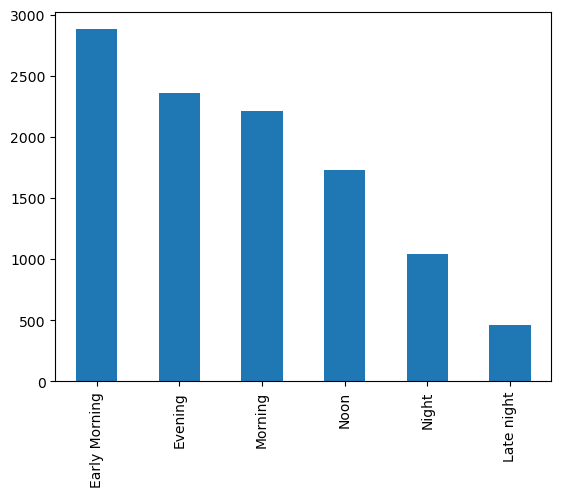

In [24]:
data['Dep_Time_Hour'].apply(flight_dep_time).value_counts().plot(kind='bar')

## lets use Cufflinks & plotly to make your visuals more interactive !

In [25]:
cf.go_offline()

In [26]:
data['Dep_Time_Hour'].apply(flight_dep_time).value_counts().iplot(kind='bar')

In [27]:
data.head(10)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h,2 stops,No info,13882,6,9,2019,9,25,4,25
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35
5,SpiceJet,Kolkata,Banglore,CCU → BLR,2h 25m,non-stop,No info,3873,24,6,2019,9,0,11,25
6,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,15h 30m,1 stop,In-flight meal not included,11087,3,12,2019,18,55,10,25
7,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,21h 5m,1 stop,No info,22270,3,1,2019,8,0,5,5
8,Jet Airways,Banglore,New Delhi,BLR → BOM → DEL,25h 30m,1 stop,In-flight meal not included,11087,3,12,2019,8,55,10,25
9,Multiple carriers,Delhi,Cochin,DEL → BOM → COK,7h 50m,1 stop,No info,8625,27,5,2019,11,25,19,15


## Pre-process Duration Feature & extract meaningful features 

In [28]:
def preprocess_duration(x):
    if 'h' not in x:
        x='0h '+x
    elif 'm' not in x:
        x=x+' 0m'
    return x
    

In [29]:
data['Duration'] = data['Duration'].apply(preprocess_duration)

In [30]:
data['Duration']

0        2h 50m
1        7h 25m
2        19h 0m
3        5h 25m
4        4h 45m
          ...  
10678    2h 30m
10679    2h 35m
10680     3h 0m
10681    2h 40m
10682    8h 20m
Name: Duration, Length: 10682, dtype: object

In [31]:
data['Duration'][0].split(' ')[0]

'2h'

In [32]:
int(data['Duration'][0].split(' ')[0][0:-1])

2

In [33]:
int(data['Duration'][0].split(' ')[1][0:-1])

50

In [34]:
data['Duration_Hours'] = data['Duration'].apply(lambda x:int(x.split(' ')[0][0:-1]))

In [35]:
data['Duration_Mins'] = data['Duration'].apply(lambda x:int(x.split(' ')[1][0:-1]))

In [36]:
data.head(3)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute,Duration_Hours,Duration_Mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0


## Lets Analyse whether Duration impacts on Price or not ?

In [37]:
data['Duration_Total_Mins']=data['Duration'].str.replace('h','*60').str.replace(' ','+').str.replace('m','*1').apply(eval)

In [38]:
data.head(2)

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute,Duration_Hours,Duration_Mins,Duration_Total_Mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25,445


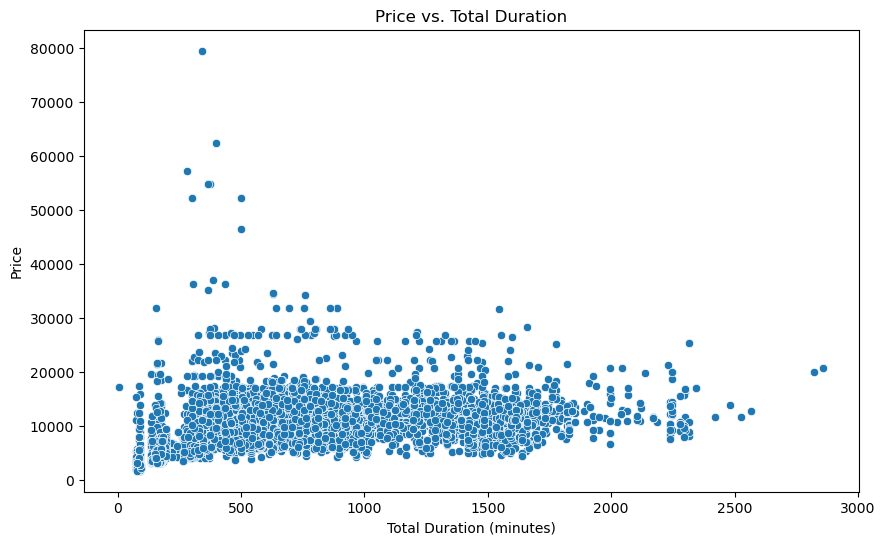

In [39]:
# Relationship between Price and Duration
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Duration_Total_Mins', y='Price', data=data)
plt.title('Price vs. Total Duration')
plt.xlabel('Total Duration (minutes)')
plt.ylabel('Price')
plt.show()

## which city has maximum final destination of flights ?

In [40]:
data['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

<AxesSubplot:ylabel='Destination'>

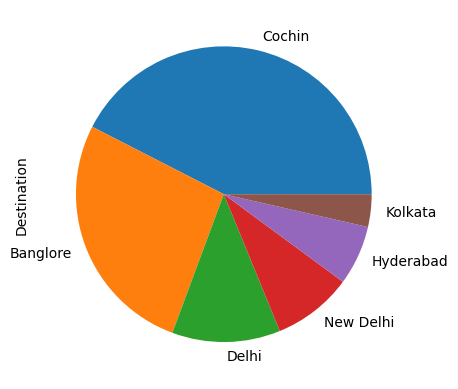

In [41]:
data['Destination'].value_counts().plot(kind = 'pie')

## Lets Perform Exploratory Data Analysis(Bivariate Analysis) to come up with some business insights
    Problem Statement-->> on which route Jet Airways is extremely used???

In [42]:
data['Route']

0                    BLR → DEL
1        CCU → IXR → BBI → BLR
2        DEL → LKO → BOM → COK
3              CCU → NAG → BLR
4              BLR → NAG → DEL
                 ...          
10678                CCU → BLR
10679                CCU → BLR
10680                BLR → DEL
10681                BLR → DEL
10682    DEL → GOI → BOM → COK
Name: Route, Length: 10682, dtype: object

In [43]:
data[data['Airline'] == 'Jet Airways'].groupby('Route').size().sort_values(ascending=False)

Route
CCU → BOM → BLR          930
DEL → BOM → COK          875
BLR → BOM → DEL          385
BLR → DEL                382
CCU → DEL → BLR          300
BOM → HYD                207
DEL → JAI → BOM → COK    207
DEL → AMD → BOM → COK    141
DEL → IDR → BOM → COK     86
DEL → NAG → BOM → COK     61
DEL → ATQ → BOM → COK     38
DEL → COK                 34
DEL → BHO → BOM → COK     29
DEL → BDQ → BOM → COK     28
DEL → LKO → BOM → COK     25
DEL → JDH → BOM → COK     23
CCU → GAU → BLR           22
DEL → MAA → BOM → COK     16
DEL → IXC → BOM → COK     13
BLR → MAA → DEL           10
BLR → BDQ → DEL            8
DEL → UDR → BOM → COK      7
BOM → DEL → HYD            5
CCU → BOM → PNQ → BLR      4
BLR → BOM → JDH → DEL      3
DEL → DED → BOM → COK      2
BOM → BDQ → DEL → HYD      2
DEL → CCU → BOM → COK      1
BOM → VNS → DEL → HYD      1
BOM → UDR → DEL → HYD      1
BOM → JDH → DEL → HYD      1
BOM → IDR → DEL → HYD      1
BOM → DED → DEL → HYD      1
dtype: int64

## Airline vs Price Analysis
    ie finding price distribution & 5-point summary of each Airline..

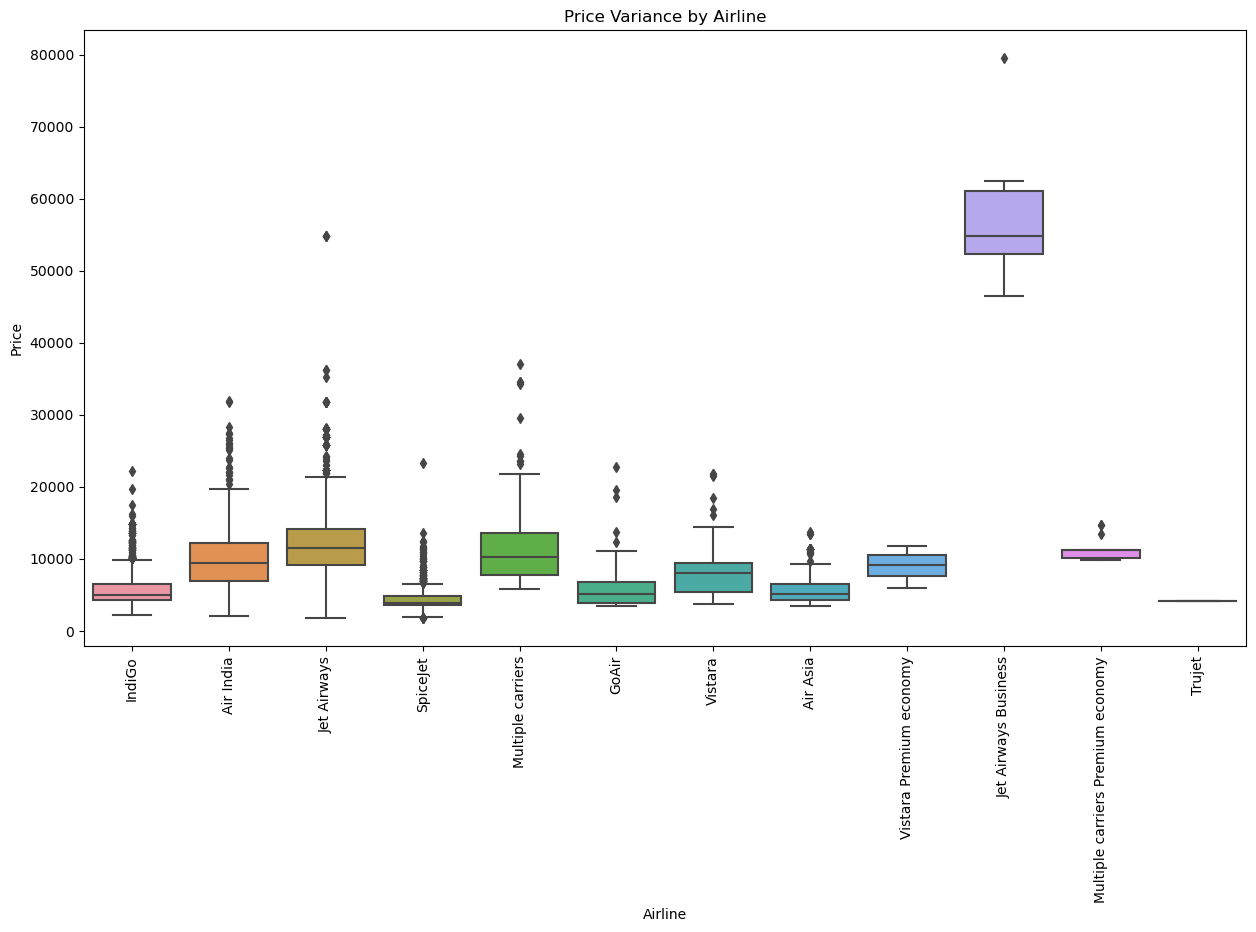

In [44]:
# Categorical Feature Analysis - Airline
plt.figure(figsize = (15, 8))
sns.boxplot(x = 'Airline', y = 'Price', data = data)
plt.title('Price Variance by Airline')
plt.xticks(rotation = 90)
plt.show()

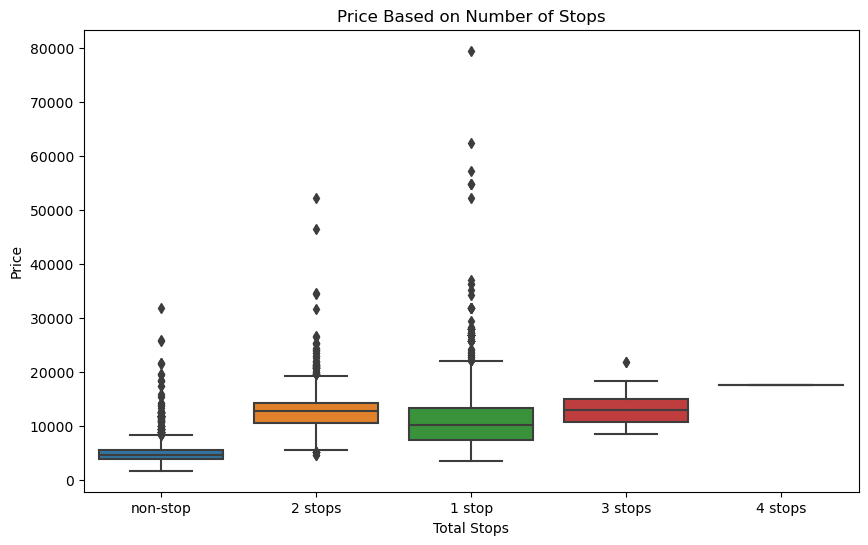

In [45]:
# Stop Analysis
plt.figure(figsize = (10, 6))
sns.boxplot(x = 'Total_Stops', y = 'Price', data = data)
plt.title('Price Based on Number of Stops')
plt.xlabel('Total Stops')
plt.ylabel('Price')
plt.show()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'IndiGo'),
  Text(1, 0, 'Air India'),
  Text(2, 0, 'Jet Airways'),
  Text(3, 0, 'SpiceJet'),
  Text(4, 0, 'Multiple carriers'),
  Text(5, 0, 'GoAir'),
  Text(6, 0, 'Vistara'),
  Text(7, 0, 'Air Asia'),
  Text(8, 0, 'Vistara Premium economy'),
  Text(9, 0, 'Jet Airways Business'),
  Text(10, 0, 'Multiple carriers Premium economy'),
  Text(11, 0, 'Trujet')])

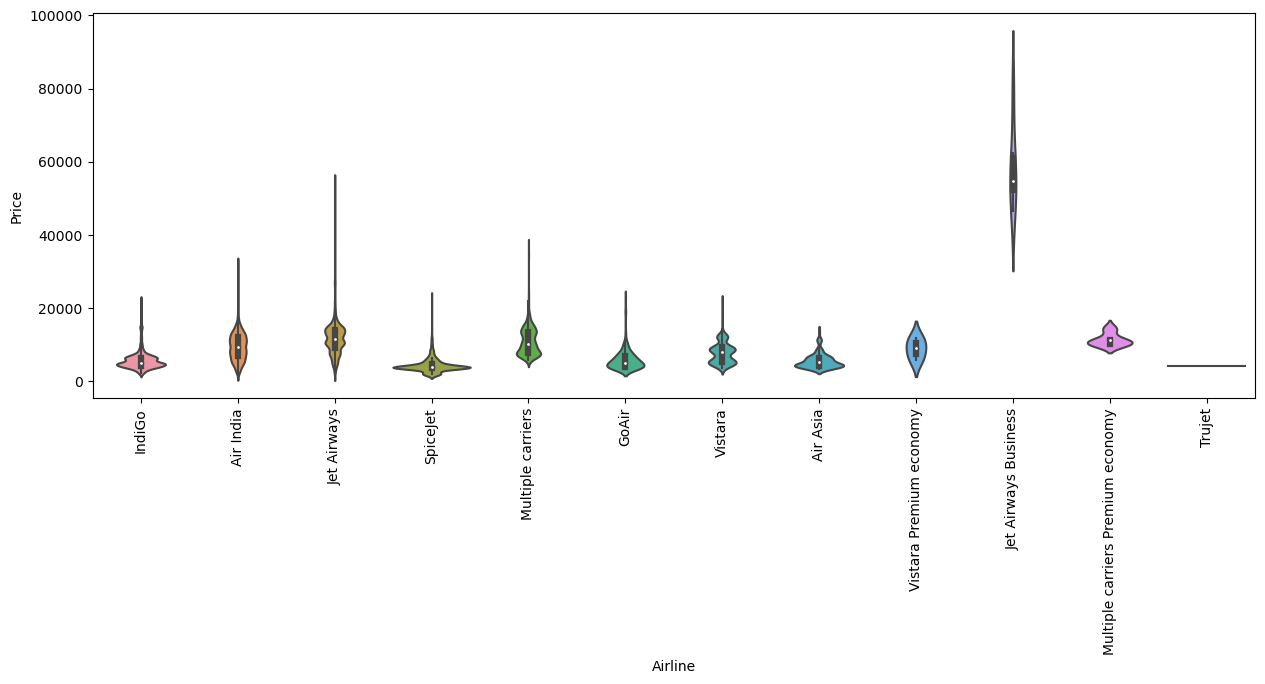

In [46]:
plt.figure(figsize = (15,5))
sns.violinplot(y = 'Price', x = 'Airline', data = data)
plt.xticks(rotation = 'vertical')

Number of unique routes: 128


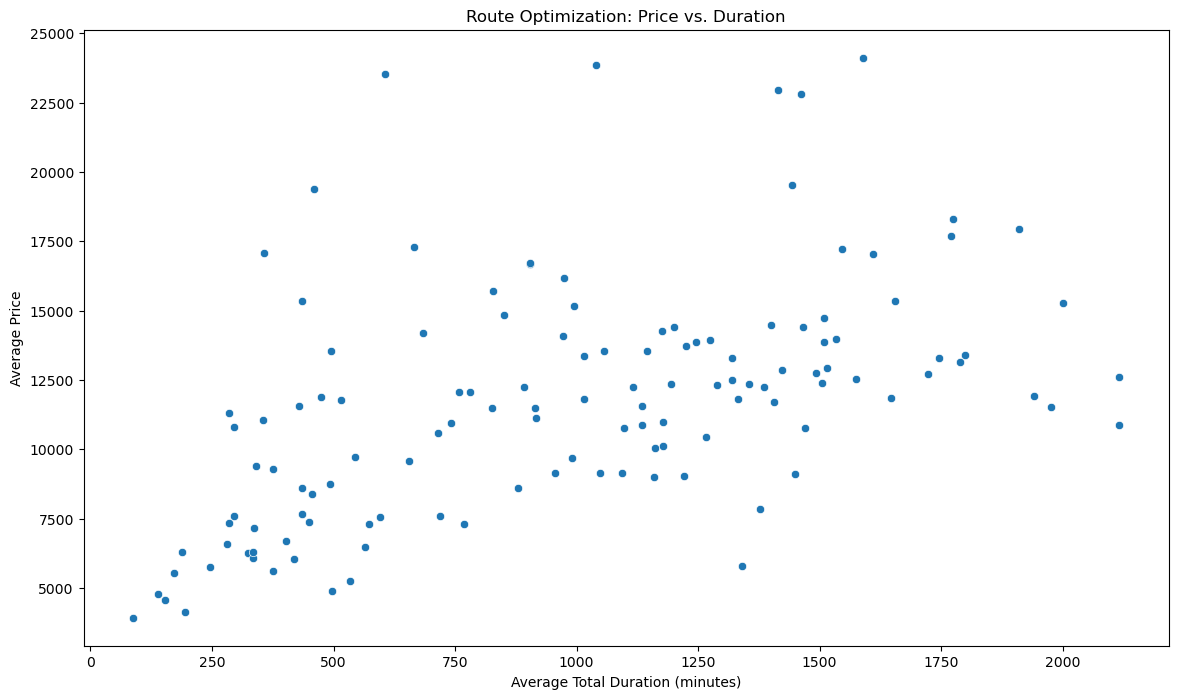

In [47]:
# Identify Unique Routes
unique_routes = data['Route'].unique()
print(f'Number of unique routes: {len(unique_routes)}')

# Analyze Routes for Optimization
# Calculate average price and duration by route
route_optimization = data.groupby('Route').agg({
    'Price': 'mean',
    'Duration_Total_Mins': 'mean'
}).reset_index()

# Visualize Optimal Routes
plt.figure(figsize = (14, 8))
sns.scatterplot(x = 'Duration_Total_Mins', y = 'Price', data = route_optimization)
plt.title('Route Optimization: Price vs. Duration')
plt.xlabel('Average Total Duration (minutes)')
plt.ylabel('Average Price')
plt.show()

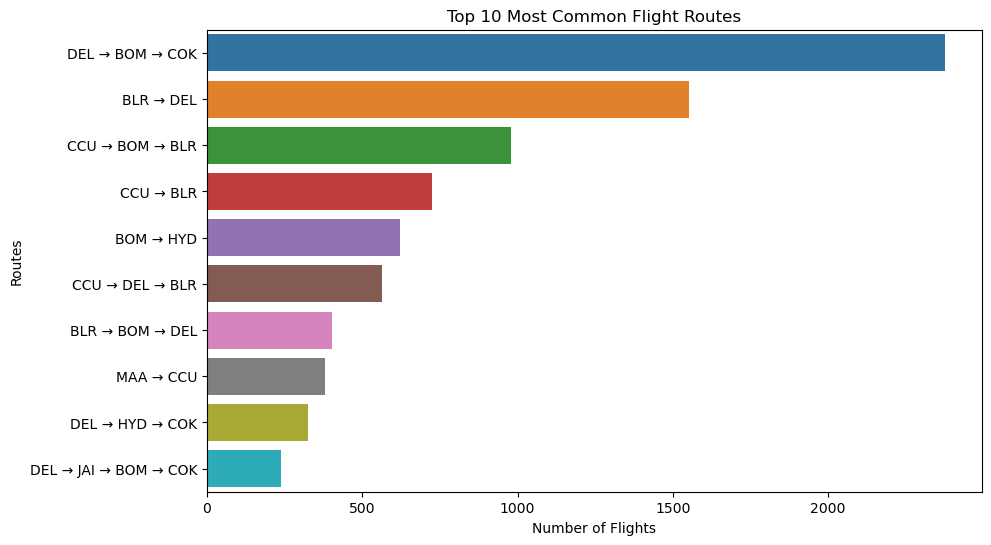

In [48]:
# Most Common Routes Plot
plt.figure(figsize = (10, 6))
common_routes = data['Route'].value_counts().head(10)
sns.barplot(y = common_routes.index, x = common_routes.values)
plt.title('Top 10 Most Common Flight Routes')
plt.xlabel('Number of Flights')
plt.ylabel('Routes')
plt.show()

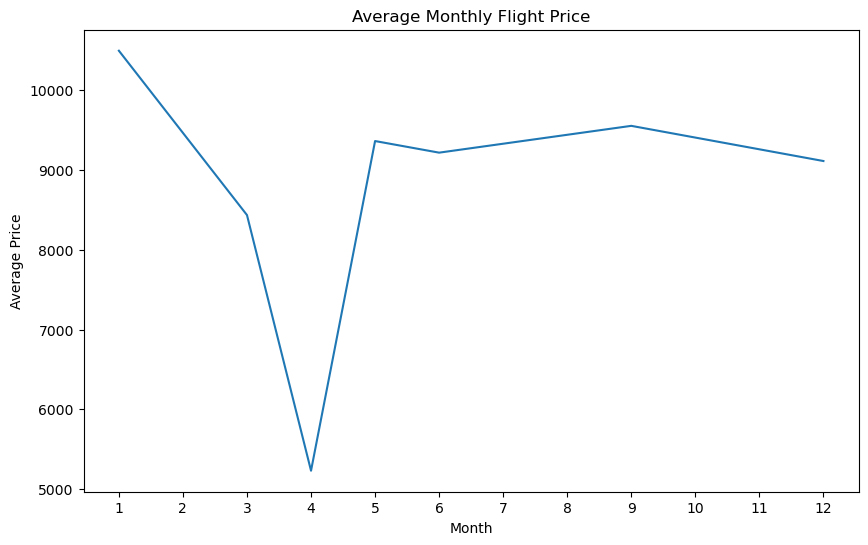

In [49]:
# Monthly Price Trend Analysis
monthly_trend = data.groupby('Journey_Month').agg({
    'Price': 'mean'
}).reset_index()

plt.figure(figsize = (10, 6))
sns.lineplot(x = 'Journey_Month', y = 'Price', data = monthly_trend)
plt.title('Average Monthly Flight Price')
plt.xlabel('Month')
plt.ylabel('Average Price')
plt.xticks(range(1, 13))
plt.show()

## Lets Perform Feature-Encoding on Data !
    Applying one-hot on data !

In [50]:
data.head()

,Airline,Source,Destination,Route,Duration,Total_Stops,Additional_Info,Price,Journey_Day,Journey_Month,Journey_Year,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute,Duration_Hours,Duration_Mins,Duration_Total_Mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,2h 50m,non-stop,No info,3897,24,3,2019,22,20,1,10,2,50,170
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,7h 25m,2 stops,No info,7662,5,1,2019,5,50,13,15,7,25,445
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,19h 0m,2 stops,No info,13882,6,9,2019,9,25,4,25,19,0,1140
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,5h 25m,1 stop,No info,6218,5,12,2019,18,5,23,30,5,25,325
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,4h 45m,1 stop,No info,13302,3,1,2019,16,50,21,35,4,45,285


In [51]:
np.round(data['Additional_Info'].value_counts()/len(data)*100,2)

No info                         78.11
In-flight meal not included     18.55
No check-in baggage included     3.00
1 Long layover                   0.18
Change airports                  0.07
Business class                   0.04
No Info                          0.03
1 Short layover                  0.01
Red-eye flight                   0.01
2 Long layover                   0.01
Name: Additional_Info, dtype: float64

In [52]:
# Additional_Info contains almost 80% no_info,so we can drop this column
# we can drop Route as well as we have pre-process that column
## lets drop Duration_total_mins as we have already extracted "Duration_hours" & "Duration_mins"

data.drop(columns = ['Additional_Info','Route','Duration_Total_Mins','Journey_Year'], axis = 1, inplace = True)

In [53]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute,Duration_Hours,Duration_Mins
0,IndiGo,Banglore,New Delhi,2h 50m,non-stop,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,7h 25m,2 stops,7662,5,1,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,19h 0m,2 stops,13882,6,9,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,5h 25m,1 stop,6218,5,12,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,4h 45m,1 stop,13302,3,1,16,50,21,35,4,45


## Lets separate categorical data & numerical data !
    categorical data are those whose data-type is 'object'
    Numerical data are those whose data-type is either int of float

In [54]:
cat_col = [col for col in data.columns if data[col].dtype=='object']

In [55]:
num_col = [col for col in data.columns if data[col].dtype!='object']

In [56]:
cat_col

['Airline', 'Source', 'Destination', 'Duration', 'Total_Stops']

## Handling Categorical Data
    We are using 2 basic Encoding Techniques to convert Categorical data into some numerical format
    if data belongs to Nominal data (ie data is not in any order) -->> OneHotEncoder is used in this case
    if data belongs to Ordinal data (ie data is in order ) -->>       LabelEncoder is used in this case

    But in real-world , it is not necessary that u have to always One-hot or label , hence we will discuss more interesting approaches to do this !

### Lets apply one-hot encoding on 'Source' feature !

In [57]:
### One-hot from scratch :

In [58]:
data['Source'].unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [59]:
data['Source']

0        Banglore
1         Kolkata
2           Delhi
3         Kolkata
4        Banglore
           ...   
10678     Kolkata
10679     Kolkata
10680    Banglore
10681    Banglore
10682       Delhi
Name: Source, Length: 10682, dtype: object

In [60]:
data['Source'].apply(lambda x: 1 if x == 'Banglore' else 0)

0        1
1        0
2        0
3        0
4        1
        ..
10678    0
10679    0
10680    1
10681    1
10682    0
Name: Source, Length: 10682, dtype: int64

In [61]:
for category in data['Source'].unique():
    data['Source_'+category]=data['Source'].apply(lambda x: 1 if x==category else 0)

In [62]:
data.head(3)

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute,Duration_Hours,Duration_Mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,IndiGo,Banglore,New Delhi,2h 50m,non-stop,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,Air India,Kolkata,Banglore,7h 25m,2 stops,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,Jet Airways,Delhi,Cochin,19h 0m,2 stops,13882,6,9,9,25,4,25,19,0,0,0,1,0,0


## Performing Target Guided Mean Encoding !
    ofcourse we can use One-hot , but if we have more sub-categories , it creates curse of dimensionality in ML..
    lets use Target Guided Mean Encoding in order to get rid of this..

In [63]:
airlines=data.groupby(['Airline'])['Price'].mean().sort_values().index

In [64]:
airlines

Index(['Trujet', 'SpiceJet', 'Air Asia', 'IndiGo', 'GoAir', 'Vistara',
       'Vistara Premium economy', 'Air India', 'Multiple carriers',
       'Multiple carriers Premium economy', 'Jet Airways',
       'Jet Airways Business'],
      dtype='object', name='Airline')

In [65]:
dict1 = {key:index for index,key in enumerate(airlines,0)}

In [66]:
dict1

{'Trujet': 0,
 'SpiceJet': 1,
 'Air Asia': 2,
 'IndiGo': 3,
 'GoAir': 4,
 'Vistara': 5,
 'Vistara Premium economy': 6,
 'Air India': 7,
 'Multiple carriers': 8,
 'Multiple carriers Premium economy': 9,
 'Jet Airways': 10,
 'Jet Airways Business': 11}

In [67]:
data['Airline'] = data['Airline'].map(dict1)

In [68]:
data['Airline']

0         3
1         7
2        10
3         3
4         3
         ..
10678     2
10679     7
10680    10
10681     5
10682     7
Name: Airline, Length: 10682, dtype: int64

In [69]:
data['Destination'].unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [70]:
data['Destination'].replace('New Delhi','Delhi',inplace=True)

In [71]:
data['Destination'].unique()

array(['Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

In [72]:
dest = data.groupby(['Destination'])['Price'].mean().sort_values().index

In [73]:
dest

Index(['Kolkata', 'Hyderabad', 'Delhi', 'Banglore', 'Cochin'], dtype='object', name='Destination')

In [74]:
dict2 = {key:index for index,key in enumerate(dest,0)}

In [75]:
dict2

{'Kolkata': 0, 'Hyderabad': 1, 'Delhi': 2, 'Banglore': 3, 'Cochin': 4}

In [76]:
data['Destination'] = data['Destination'].map(dict2)

In [77]:
data['Destination']

0        2
1        3
2        4
3        3
4        2
        ..
10678    3
10679    3
10680    2
10681    2
10682    4
Name: Destination, Length: 10682, dtype: int64

In [78]:
data.head()

,Airline,Source,Destination,Duration,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute,Duration_Hours,Duration_Mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,Banglore,2,2h 50m,non-stop,3897,24,3,22,20,1,10,2,50,1,0,0,0,0
1,7,Kolkata,3,7h 25m,2 stops,7662,5,1,5,50,13,15,7,25,0,1,0,0,0
2,10,Delhi,4,19h 0m,2 stops,13882,6,9,9,25,4,25,19,0,0,0,1,0,0
3,3,Kolkata,3,5h 25m,1 stop,6218,5,12,18,5,23,30,5,25,0,1,0,0,0
4,3,Banglore,2,4h 45m,1 stop,13302,3,1,16,50,21,35,4,45,1,0,0,0,0


### Perform Manual Encoding on Total_stops feature

In [79]:
data['Total_Stops'].unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', '4 stops'],
      dtype=object)

In [80]:
stops={'non-stop':0, '2 stops':2, '1 stop':1, '3 stops':3, '4 stops':4}

In [81]:
data['Total_Stops']=data['Total_Stops'].map(stops)

In [82]:
data['Total_Stops']

0        0
1        2
2        2
3        1
4        1
        ..
10678    0
10679    0
10680    0
10681    0
10682    2
Name: Total_Stops, Length: 10682, dtype: int64

## Performing Outlier Detection !
    Here the list of data visualization plots to spot the outliers.
1. Box and whisker plot (box plot).
2. Scatter plot.
3. Histogram.
4. Distribution Plot.
5. QQ plot

In [83]:
def plot(df,col):

    fig,(ax1,ax2,ax3) = plt.subplots(3,1)
    sns.histplot(df[col],ax = ax1)
    sns.boxplot(df[col],ax = ax2)
    sns.histplot(df[col],ax = ax3, kde = True)
    

/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



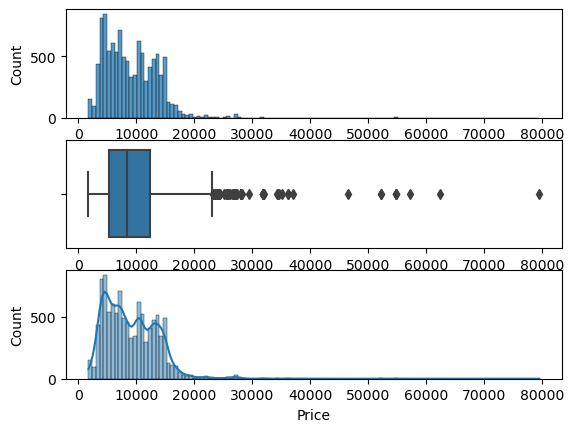

In [84]:
plot(data,'Price')

### getting a high level over-view of various ways to deal with outliers:


In [85]:
data['Price'] = np.where(data['Price'] >= 35000, data['Price'].median(),data['Price'])

/Users/ramanujsharma/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



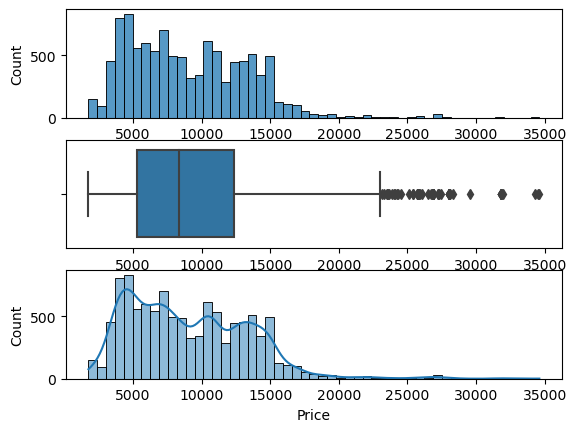

In [86]:
plot(data,'Price')

In [87]:
data.drop(columns = ['Source','Duration'],axis = 1,inplace = True)

In [88]:
data.head()

,Airline,Destination,Total_Stops,Price,Journey_Day,Journey_Month,Dep_Time_Hour,Dep_Time_Hinute,Arrival_Time_Hour,Arrival_Time_Hinute,Duration_Hours,Duration_Mins,Source_Banglore,Source_Kolkata,Source_Delhi,Source_Chennai,Source_Mumbai
0,3,2,0,3897.0,24,3,22,20,1,10,2,50,1,0,0,0,0
1,7,3,2,7662.0,5,1,5,50,13,15,7,25,0,1,0,0,0
2,10,4,2,13882.0,6,9,9,25,4,25,19,0,0,0,1,0,0
3,3,3,1,6218.0,5,12,18,5,23,30,5,25,0,1,0,0,0
4,3,2,1,13302.0,3,1,16,50,21,35,4,45,1,0,0,0,0


## Performing Feature Selection !

In [89]:
X = data.drop(['Price'], axis = 1)
y = data['Price']
X.dtypes

Airline                int64
Destination            int64
Total_Stops            int64
Journey_Day            int64
Journey_Month          int64
Dep_Time_Hour          int64
Dep_Time_Hinute        int64
Arrival_Time_Hour      int64
Arrival_Time_Hinute    int64
Duration_Hours         int64
Duration_Mins          int64
Source_Banglore        int64
Source_Kolkata         int64
Source_Delhi           int64
Source_Chennai         int64
Source_Mumbai          int64
dtype: object

In [90]:
mutual_info_regression(X,y)

array([1.31331675, 1.06525786, 0.78660805, 0.60696121, 0.42325485,
       0.92678257, 0.76101343, 1.14083343, 0.90368191, 1.12840356,
       0.67240425, 0.39158279, 0.45807138, 0.52283766, 0.1317934 ,
       0.20278547])

In [91]:
imp = pd.DataFrame(mutual_info_regression(X,y), index = X.columns)
imp.columns = ['importance']

In [92]:
imp.sort_values(by = 'importance', ascending = False)

,importance
Airline,1.317022
Arrival_Time_Hour,1.140170
Duration_Hours,1.118443
Destination,1.069013
Dep_Time_Hour,0.931540
Arrival_Time_Hinute,0.908174
Total_Stops,0.794297
Dep_Time_Hinute,0.751519
Duration_Mins,0.682513
Journey_Day,0.603440


## Lets build ML Model  , then later on we can think of saving it..

#### split dataset into train & test

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

#### what we often do in modelling:
    a..Initially ,lets build basic random forest model.
    b..then later-on , we will try to improve this model using some parameters..
    c..Then we will hyper-tune my model to get optimal value of parameters in order to achieve optimal value of params..

In [94]:
ml_model=RandomForestRegressor()
model=ml_model.fit(X_train,y_train)
y_pred=model.predict(X_test)
y_pred

array([16704.41,  6527.69,  8845.34, ...,  3526.04,  6340.83,  6893.14])

In [95]:
y_pred.shape

(2671,)

In [96]:
len(X_test)

2671

### How to save ML model into disk

In [97]:
### !pip install pickle

In [98]:
# Use a relative path or a shorter directory name
directory = 'flight_ticket_price_prediction'
os.makedirs(directory, exist_ok=True)

file_path = os.path.join(directory, 'rf_random.pkl')

# Saving the model
with open(file_path, 'wb') as file:
    pickle.dump(model, file)

# Loading the model
with open(file_path, 'rb') as model_file:
    forest = pickle.load(model_file)

# Making predictions
forest.predict(X_test)

array([16704.41,  6527.69,  8845.34, ...,  3526.04,  6340.83,  6893.14])

## Defining your own evaluation metric :

In [99]:
def mape(y_true,y_pred):
    y_true,y_pred=np.array(y_true),np.array(y_pred)
    
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [100]:
mape(y_test,forest.predict(X_test))

13.256430620183496

## How to Automate ML Pipeline :

In [101]:
def predict(ml_model):
    
    model = ml_model.fit(X_train,y_train)
    print('Training_score: {}'.format(model.score(X_train,y_train)))
    y_prediction=model.predict(X_test)
    print('Predictions are : {}'.format(y_prediction))
    print('\n')
    
    r2_score = metrics.r2_score(y_test, y_prediction)
    print('r2_score: {}'.format(r2_score))
    print('MSE : ', metrics.mean_squared_error(y_test, y_prediction))
    print('MAE : ', metrics.mean_absolute_error(y_test, y_prediction))
    print('RMSE : ', np.sqrt(metrics.mean_squared_error(y_test,y_prediction)))
    print('MAPE : ', mape(y_test,y_prediction))
    sns.kdeplot(y_test-y_prediction)
    

Training_score: 0.9519598739847852
Predictions are : [16611.29  6272.66  8741.55 ...  3498.12  6289.24  7000.49]


r2_score: 0.8089679861422112
MSE :  3718934.7690643347
MAE :  1182.2403798724258
RMSE :  1928.4539841708265
MAPE :  13.273449156513745


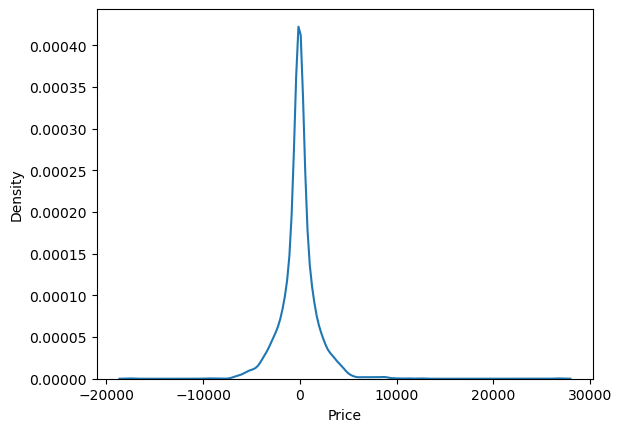

In [102]:
predict(RandomForestRegressor())

## how to hypertune ml model
    Hyperparameter Tuning or Hyperparameter Optimization
    1.Choose following method for hyperparameter tuning
        a.RandomizedSearchCV --> Fast way to Hypertune model
        b.GridSearchCV--> Slow way to hypertune my model
    2.Choose ML algo that u have to hypertune
    2.Assign hyperparameters in form of dictionary or create hyper-parameter space
    3.define searching &  apply searching on Training data or  Fit the CV model 
    4.Check best parameters and best score

In [103]:
### initialise your estimator
reg_rf=RandomForestRegressor()

In [104]:
np.linspace(start = 1000, stop = 1200, num = 6)

array([1000., 1040., 1080., 1120., 1160., 1200.])

In [105]:
# Number of trees in random forest
n_estimators=[int(x) for x in np.linspace(start=1000,stop=1200,num=6)]

# Number of features to consider at every split
max_features=["auto", "sqrt"]

# Maximum number of levels in tree
max_depth=[int(x) for x in np.linspace(start=5,stop=30,num=4)]

# Minimum number of samples required to split a node
min_samples_split=[5,10,15,100]

In [106]:
# Create the grid or hyper-parameter space
random_grid={
    'n_estimators':n_estimators,
    'max_features':max_features,
    'max_depth':max_depth,
    'min_samples_split':min_samples_split
    
}

In [107]:
random_grid

{'n_estimators': [1000, 1040, 1080, 1120, 1160, 1200],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [5, 13, 21, 30],
 'min_samples_split': [5, 10, 15, 100]}

In [108]:
rf_Random=RandomizedSearchCV(reg_rf,param_distributions=random_grid,cv=3,verbose=2,n_jobs=-1)

In [109]:
random_grid = {
    'n_estimators': [1000, 1040, 1080, 1120, 1160, 1200],
    'max_features': ['sqrt', 'log2'],  # Remove 'auto'
    'max_depth': [5, 13, 21, 30],
    'min_samples_split': [5, 10, 15, 100]
}

rf_Random = RandomizedSearchCV(estimator=reg_rf, param_distributions=random_grid, cv=3, verbose=2, n_jobs=-1)
rf_Random.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=5, max_features=log2, min_samples_split=100, n_estimators=1040; total time=   3.5s
[CV] END max_depth=5, max_features=log2, min_samples_split=100, n_estimators=1040; total time=   3.6s
[CV] END max_depth=5, max_features=log2, min_samples_split=100, n_estimators=1040; total time=   3.6s
[CV] END max_depth=13, max_features=log2, min_samples_split=15, n_estimators=1000; total time=   6.4s
[CV] END max_depth=13, max_features=log2, min_samples_split=15, n_estimators=1000; total time=   6.4s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=15, n_estimators=1040; total time=   7.0s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=15, n_estimators=1040; total time=   7.0s
[CV] END max_depth=21, max_features=sqrt, min_samples_split=15, n_estimators=1040; total time=   7.2s
[CV] END max_depth=30, max_features=sqrt, min_samples_split=100, n_estimators=1080; total time=   5.3s
[CV] END max_depth=3

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 13, 21, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_split': [5, 10, 15, 100],
                                        'n_estimators': [1000, 1040, 1080, 1120,
                                                         1160, 1200]},
                   verbose=2)

In [110]:
### to get your best model..
rf_Random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 15,
 'max_features': 'log2',
 'max_depth': 30}

In [111]:
pred2 = rf_Random.predict(X_test)

In [112]:
metrics.r2_score(y_test,pred2)

0.817511811762379